## What are autoencoders? ##
    
Autoencoders are a type of unsupervised neural network (i.e., no class labels or labeled data) that seek to:

1. Accept an input set of data (i.e., the input).
2. Internally compress the input data into a latent-space representation (i.e., a single vector that compresses and quantifies the input).
3. Reconstruct the input data from this latent representation (i.e., the output).

Typically, we think of an autoencoder having two components/subnetworks:

1. Encoder: Accepts the input data and compresses it into the latent-space. If we denote our input data as x and the encoder as E, then the output latent-space representation, s, would be s = E(x).
2. Decoder: The decoder is responsible for accepting the latent-space representation s and then reconstructing the original input. If we denote the decoder function as D and the output of the detector as o, then we can represent the decoder as o = D(s).


In [1]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ConvAutoencoder(object):
    def __init__ (self, width, height, depth, filters, latentDim, learning_rate=1e-3):
        '''
        Inputs:
            width(int): Width of the input image in pixels.
            height(int): Height of the input image in pixels.
            depth(int): Number of channels (i.e., depth) of the input volume.
            filters(tuple(int)): A tuple that contains the set of filters for convolution operations.
            latentDim(int): The number of neurons in our fully-connected (Dense) latent vector
        '''
        self.width = width
        self.height = height
        self.depth = depth
        self.filters = filters
        self.latentDim = latentDim
        self.learning_rate = learning_rate
        self.optimizer = Adam(learning_rate)
        self.encoder, self.decoder, self.autoencoder = self.create_nets(width, height, depth, filters, latentDim)
        
    #-------------------------------------------------------------------------------------------------------------------       
    def create_nets(self, width, height, depth, filters, latentDim):
        inputShape = (height, width, depth)
        chanDim = -1
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")

        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        autoencoder.compile(loss="mse", optimizer=self.optimizer)
        # return 3 networks
        return encoder, decoder, autoencoder
    
    #-------------------------------------------------------------------------------------------------------------------
    def train(self, epochs, batch_size, train_data, train_label, val_data, val_label):
        self.autoencoder.fit(
            train_data, 
            train_label, 
            validation_data=(val_data, val_label), 
            epochs=epochs, 
            batch_size=batch_size
        )


In [3]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder(28, 28, 1, (32, 64), 16)

[INFO] loading MNIST dataset...
[INFO] building autoencoder...


In [4]:
autoencoder.train(EPOCHS, BS, trainX, trainX, testX, testX)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 102s 2ms/sample - loss: 0.0184 - val_loss: 0.0112
Epoch 2/25
60000/60000 [==============================] - 98s 2ms/sample - loss: 0.0104 - val_loss: 0.0097
Epoch 3/25
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.0094 - val_loss: 0.0088
Epoch 4/25
60000/60000 [==============================] - 105s 2ms/sample - loss: 0.0088 - val_loss: 0.0085
Epoch 5/25
60000/60000 [==============================] - 91s 2ms/sample - loss: 0.0085 - val_loss: 0.0082
Epoch 6/25
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.0082 - val_loss: 0.0080
Epoch 7/25
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/25
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.0077 - val_loss: 0.0078
Epoch 9/25
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.0076

In [ ]:
np.shape(testX)
tst = testX[1]

In [9]:
pred = autoencoder.autoencoder.predict(tst[np.newaxis, :])

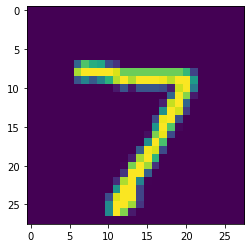

In [10]:
plt.imshow(np.squeeze(tst))

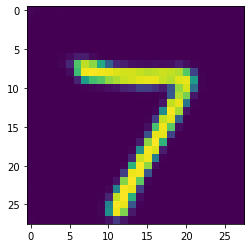

In [11]:
plt.imshow(np.squeeze(pred))